### References:
* https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization
* http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/
* https://www.kaggle.com/yohanb/lda-visualized-using-t-sne-and-bokeh
* https://github.com/ravishchawla/word_2_vec/blob/master/word_2_vec.ipynb

## Initiliaze

In [1]:
%pylab inline

import pandas as pd
import pickle as pk
import nltk
import re
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

import nltk.data;

from gensim.models import word2vec;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;

In [3]:
path_to_data = '../../data/reddit_comments_askDocs_2014_to_2018_03.gz'
df = pd.read_csv(path_to_data,dtype={'body':str,'score_hidden':float})
print('Shape',df.shape)
df.head(2)

Shape (557648, 21)


/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,for a manlet such as yourself I'd recommend at...,NaN,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,...,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,NaN,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,...,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN


In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');

The next function will be called on the comments, and will clean the data. We will apply several pre-processing steps to it.

Remove all escape-tabs and escape-newlines
Remove all non symbol characters (except for the dot)
Normalize spaces to a single character
Remove leading and trailing spaces
Tokenizing the text into sentences
Because it takes a long time to clean the entire comments data, the function has been written to take a file name as an argument. Instead of saving the cleaned text in memory, it will be written to this file instead, to help avoid a kernel crash in case the process runs out of memory.

In [7]:
def clean_text(all_comments, out_name):
    
    out_file = open(out_name, 'w');
    total_rows=len(all_comments)
    print("total_rows:",total_rows)
    for pos in range(len(all_comments)):
        
        #Get the comment
        val = all_comments.iloc[pos]['body'];
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '');
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", alphas_only);
        
        #Strip trailing and leading spaces
        no_spaces = multi_spaces.strip();
        
        #Normalize all charachters to lowercase
        clean_text = no_spaces.lower();
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(clean_text);
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];
        
        #If the text has more than one space (removing single word comments) and one character, write it to the file.
        if len(clean_text) > 0 and clean_text.count(' ') > 0:
            for sentence in sentences:
                out_file.write("%s\n" % sentence)
        
    out_file.close();

In [8]:
start  = time.time()
clean_comments  = clean_text(df, '../../data/nltk_cleaned_comments.txt')
print('Total time: ' + str((time.time() - start)) + ' secs')

total_rows: 557648
Total time: 179.22814416885376 secs


In [33]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 200;    # Dimensionality of the hidden layer representation
min_word_count = 40;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count() -1;       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words
iterations = 15
sg = 1 # 1 for skip-gram, 0 for cbow

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(word2vec.LineSentence('../../data/nltk_cleaned_comments.txt'), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling,iter=iterations,sg=sg);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);

# Save the model
model_name = "model_full_reddit";
model.save(model_name);

print('Total time: ' + str((time.time() - start)) + ' secs')

2018-07-04 10:35:24,268 : INFO : collecting all words and their counts
2018-07-04 10:35:24,272 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-04 10:35:24,340 : INFO : PROGRESS: at sentence #10000, processed 143041 words, keeping 9857 word types
2018-07-04 10:35:24,398 : INFO : PROGRESS: at sentence #20000, processed 278887 words, keeping 14636 word types
2018-07-04 10:35:24,465 : INFO : PROGRESS: at sentence #30000, processed 444433 words, keeping 18844 word types


Training model...


2018-07-04 10:35:24,535 : INFO : PROGRESS: at sentence #40000, processed 612092 words, keeping 21955 word types
2018-07-04 10:35:24,596 : INFO : PROGRESS: at sentence #50000, processed 771210 words, keeping 24918 word types
2018-07-04 10:35:24,660 : INFO : PROGRESS: at sentence #60000, processed 938508 words, keeping 27703 word types
2018-07-04 10:35:24,722 : INFO : PROGRESS: at sentence #70000, processed 1100804 words, keeping 30157 word types
2018-07-04 10:35:24,788 : INFO : PROGRESS: at sentence #80000, processed 1279957 words, keeping 32758 word types
2018-07-04 10:35:24,853 : INFO : PROGRESS: at sentence #90000, processed 1449012 words, keeping 35104 word types
2018-07-04 10:35:24,920 : INFO : PROGRESS: at sentence #100000, processed 1631296 words, keeping 38071 word types
2018-07-04 10:35:24,979 : INFO : PROGRESS: at sentence #110000, processed 1777663 words, keeping 39847 word types
2018-07-04 10:35:25,045 : INFO : PROGRESS: at sentence #120000, processed 1950567 words, keeping 

Total time: 467.5578360557556 secs


In [34]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means  object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [35]:
Z = model.wv.syn0;
start = time.time()
centers, clusters = clustering_on_wordvecs(Z, 50);
print('Total time: ' + str((time.time() - start)) + ' secs')

/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Total time: 12.012041091918945 secs


In [36]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.00639796257019043 secs


In [37]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [39]:
top_words = get_top_words(model.wv.index2word, 20, centers, Z);

In [40]:
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19,Cluster #20,Cluster #21,Cluster #22,Cluster #23,Cluster #24,Cluster #25,Cluster #26,Cluster #27,Cluster #28,Cluster #29,Cluster #30,Cluster #31,Cluster #32,Cluster #33,Cluster #34,Cluster #35,Cluster #36,Cluster #37,Cluster #38,Cluster #39,Cluster #40,Cluster #41,Cluster #42,Cluster #43,Cluster #44,Cluster #45,Cluster #46,Cluster #47,Cluster #48,Cluster #49,Cluster #50
1,lupus,edn,nauseous,reddish,wellbutrin,mart,among,fruit,ignorant,neurologist,dust,calorie,goes,scalpel,virus,insurance,associated,replies,backward,tea,got,bike,iud,wwwmedscapecom,depression,doxycycline,eyelashes,scary,sister,nose,yeah,ligament,cyst,synthesis,manage,mesenteric,flipping,ecg,socks,scintillating,forearm,week,lotion,appropriate,fluticasone,ldh,scientific,nummular,ei,texas
2,erythematosus,remindmebot,dizzy,brown,lexapro,store,variants,avocados,judgmental,gastroenterologist,dander,kcal,gets,pierced,chlamydia,medicaid,suggestive,reply,holding,unsweetened,had,boxing,intercourse,page,delusions,antibiotic,flaky,frustrating,wife,sinuses,lol,ligaments,spermatocele,secreted,overwhelm,haemorrhage,crazy,pulse,waterproof,scotoma,buttock,month,vaseline,conservative,fexofenadine,tibc,empirical,corporis,ved,ohio
3,autoimmune,cannawen,dizziness,pinkish,xanax,wal,individuals,salads,selfish,specialist,mites,caloric,stops,hole,gonorrhoea,company,related,upvoted,laying,soda,saw,basketball,ovulating,assets,ocd,azithromycin,peeling,annoying,mother,mucus,haha,humerus,fibroma,activates,address,artery,lol,heart,shoes,visual,thigh,months,moisturizer,necessary,antacid,transferrin,scientifically,tinea,oe,washington
4,sle,deletthis,nausea,whitish,prozac,brand,ethnic,vegetables,arrogant,gp,soil,weight,comes,needle,mrsa,federal,manifestation,advice,chair,juice,went,jogging,ovulation,onlinelibrarywileycom,ptsd,fluconazole,scabs,unsettling,brother,passages,yea,tfcc,epidermoid,inhibits,convince,ischemic,freaking,ekg,undies,myokymia,humerus,weeks,aveeno,recommending,ranitidine,hemoglobin,data,keratolysis,cj,columbia
5,sarcoidosis,readmemd,lightheadedness,yellow,zoloft,buy,populations,potatoes,rude,pcp,mould,calories,reaches,staples,hpv,policy,indicative,commenting,recliner,lemonade,discovered,biking,mirena,pdf,depressive,erythromycin,scabbing,awful,mom,throat,anyway,scapular,sebaceous,acetylcholine,improve,obstruction,fucking,rhythm,shorts,aphasia,palm,days,hibiclens,approach,ibuprofen,serum,science,seborrheic,biw,virginia
6,sj,tometric,lightheaded,darker,effexor,pharmacy,subset,carrots,snarky,urologist,plants,expenditure,passes,clamp,varicella,employer,cause,comment,ceiling,powerade,told,hike,pregnant,http,personality,augmentin,skin,frightening,father,trachea,honestly,ulna,cysts,inhibit,recognize,subdural,shit,arrhythmia,breathable,horner,arm,sunday,cetaphil,alternative,omeprazole,mch,evidence,ringworm,cache,usa
7,fibromyalgia,excludeme,disorientation,yellowish,adderall,walmart,commonly,veggies,offended,orthopedic,mold,macros,gives,gaping,herpes,billing,characteristic,replying,tilted,water,visited,football,pregnancy,wwwsciencedirectcom,bipolar,metronidazole,flaking,terrifying,dad,eustachian,i,impingement,lipoma,byproducts,motivate,infarction,shitting,ventricular,gloves,papilledema,elbow,six,ointment,interventions,zantac,sedimentation,flawed,dermatofibroma,fd,city
8,hashimoto,kittenswolf,nauseas,colour,celexa,costco,population,quinoa,pushy,ent,carpet,bmi,starts,embedded,ebv,reimbursement,caused,pasted,sofa,lemon,realized,jog,menstruation,articles,schizoaffective,antibiotics,hairs,depressing,husband,mucous,anyways,peroneal,submandibular,deplete,identify,stenosis,fucked,tachycardia,shirt,nystagmus,ribs,friday,moisturiser,option,cetirizine,alp,clinical,cruris,gclid,university
9,scleroderma,wikitextbot,woozy,color,bupropion,sells,subtypes,celery,condescending,phy

In [41]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

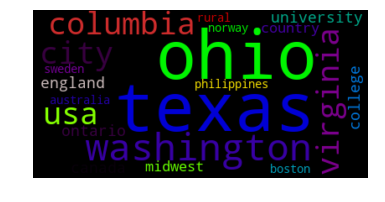

In [42]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)

In [57]:
def  get_word_table(table, key, sim_key='similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns=[key, sim_key])
    else:
        return pd.DataFrame(table, columns=[key, sim_key])[key]

In [61]:
get_word_table(model.wv.most_similar_cosmul(positive=['heal'], negative=['pain','stomach']), 'Analogy')

,Analogy,similarity
0,leave,3.332859
1,anyway,3.270688
2,dermatologist,3.260804
3,healing,3.212337
4,clean,3.169578
5,professional,3.097806
6,grow,3.081437
7,cover,3.072386
8,remove,3.061625
9,fungal,3.049295


Although 'heal' is not the first keyword here, some of the other words also fall in the same category.

We can also use Word2Vec to find the word that doesn't match the context of other words in a group.

In [55]:
model.wv.doesnt_match("chronic pain stomach creatinine".split())

'chronic'

In [46]:
keys = ['pain','disease','emergency','thanks','abx','antibiotics','male','female']
tables = [];
for key in keys:
    tables.append(get_word_table(model.wv.similar_by_word(key), key, show_sim=False))
pd.concat(tables, axis=1)

,pain,disease,emergency,thanks,abx,antibiotics,male,female
0,discomfort,diseases,er,thank,antibiotics,abx,female,male
1,pains,lyme,urgent,thx,antibiotic,antibiotic,woman,woman
2,ache,celiac,emergent,thankyou,bactrim,doxycycline,yo,females
3,dull,crohn,department,ty,cipro,azithromycin,caucasian,caucasian
4,radiating,sarcoidosis,emergencies,reply,clindamycin,biotics,men,yo
5,soreness,autoimmune,ambulance,appreciate,amoxicillin,cipro,males,women
6,aching,erythematosus,ed,itthanks,levaquin,flagyl,females,males
7,nausea,parkinson,room,cheers,antifungals,augmentin,old,men
8,headache,alzheimer,hospital,input,vancomycin,amoxicillin,yr,menopausal
9,tightness,sj,emerg,replying,keflex,antifungals,uncircumcised,old


## Multi-dimensional View of Word Vectors

In [64]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    print('Num words: {}'.format(len(model.wv.vocab)))
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = sklearn.manifold.TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(27, 27)) 
    x_offset = 0.2
    y_offset = 1.2
    
    # > 1 spreads items out more, < 1 condenses more
    x_multiplication = 1.01
    y_multiplication = 1.01
    for i in range(len(x)):
        plt.scatter((x[i]*x_multiplication)+x_offset,(y[i]*y_multiplication)+y_offset)
        plt.annotate(labels[i],
                     xy=((x[i]*x_multiplication)+x_offset, (y[i]*y_multiplication)),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [40]:
%%time
model = word2vec.Word2Vec(word2vec.LineSentence('../../data/nltk_cleaned_comments.txt'), size=200, 
                          sample = 8e-4,   # Downsample setting for frequent words
                          compute_loss=True,
                          window=20, 
                          iter=15,
                          min_count=2000,
                          workers=8)

CPU times: user 11min 34s, sys: 10.2 s, total: 11min 45s
Wall time: 4min 40s


Num words: 1209


/Users/austinpowell/Google_Drive/kp_datascience/virtual_envs/nlp-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


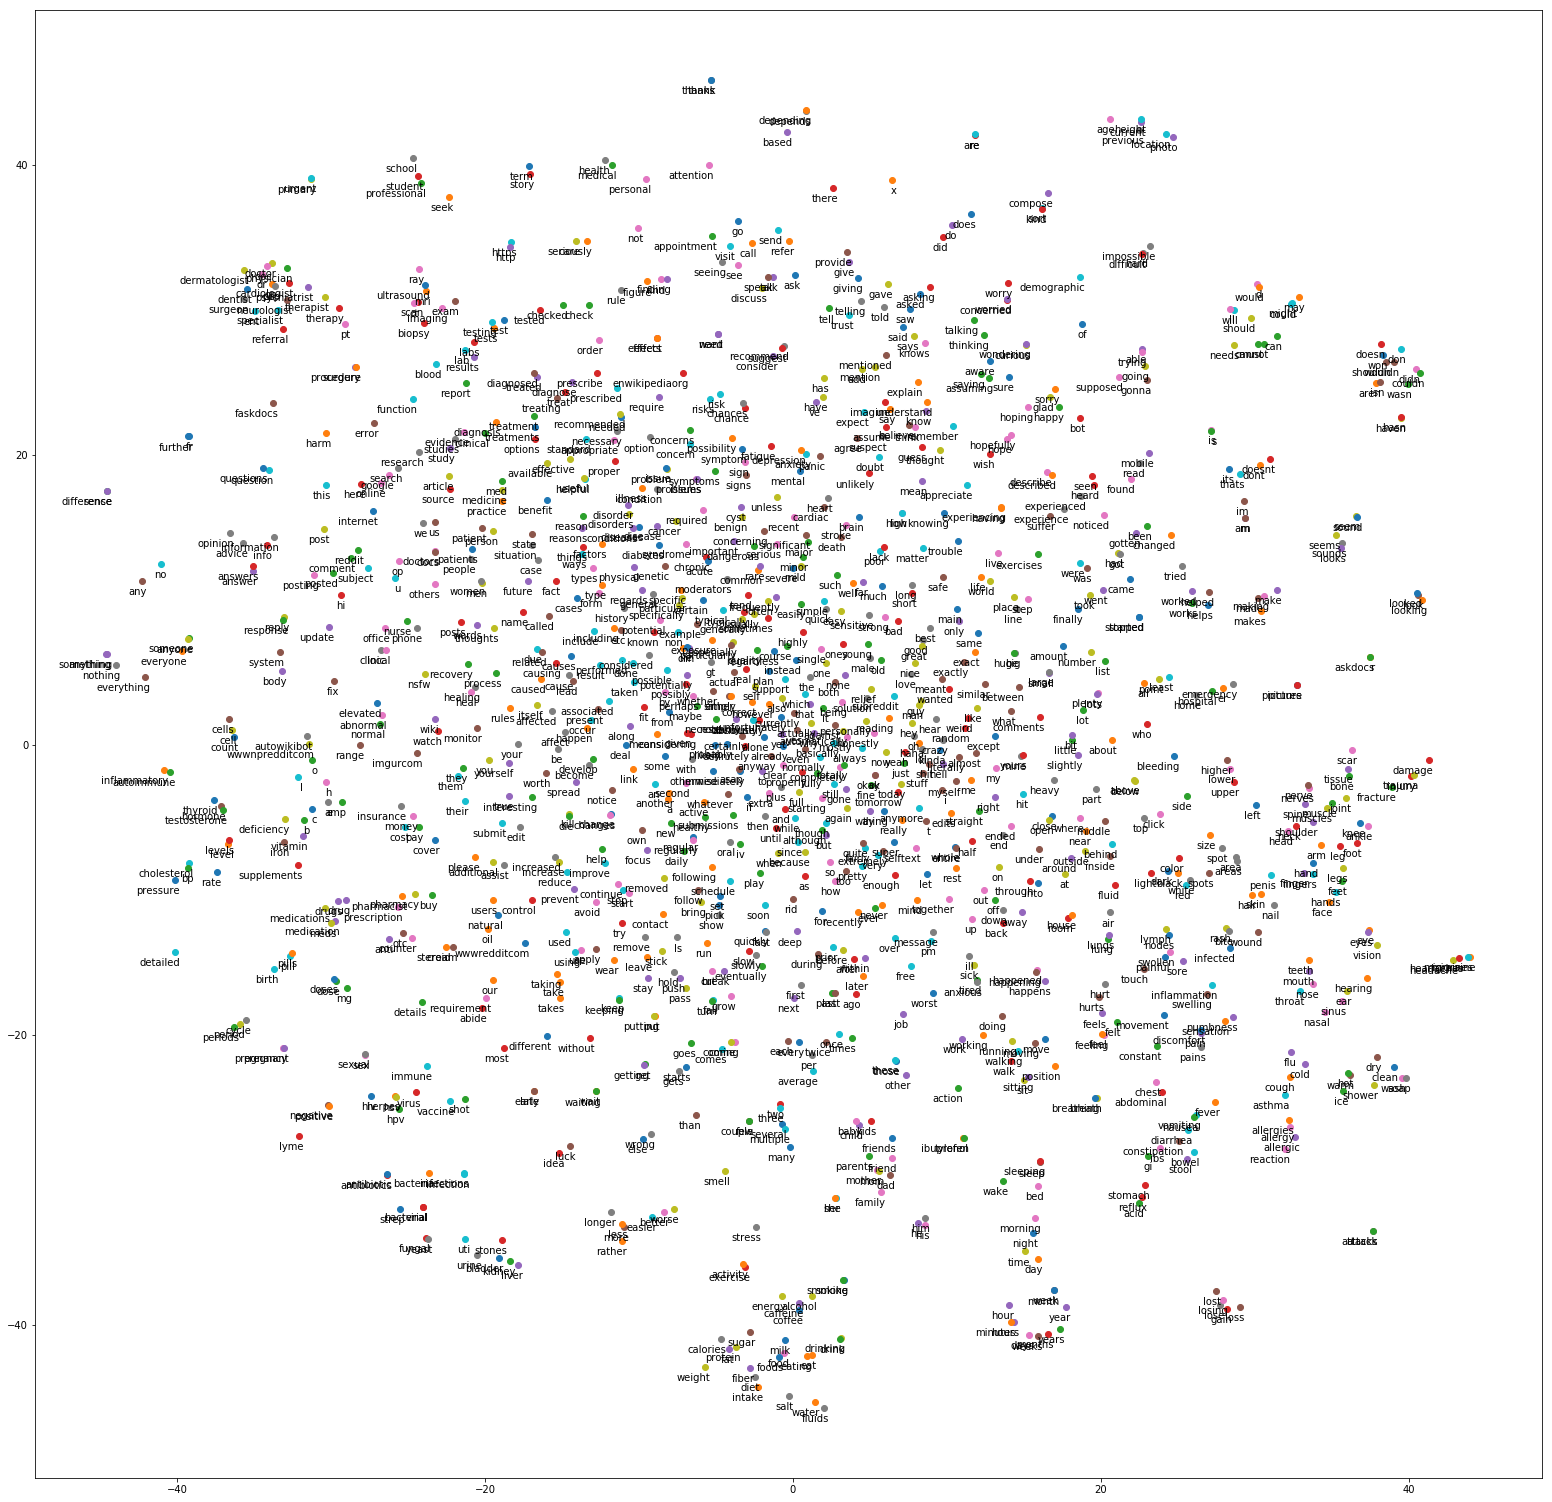

CPU times: user 1min 22s, sys: 8.77 s, total: 1min 31s
Wall time: 1min 31s


In [65]:
%%time
import sklearn
tsne_plot(model)